/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
[GRAPHCUT] step1 elapsed: 1.1693751811981201
[GRAPHCUT] step2 elapsed: 0.014671564102172852
[GRAPHCUT] step3 elapsed: 0.009179115295410156
[GRAPHCUT] step4 elapsed: 9.118926286697388
elapsed 10.31464433670044


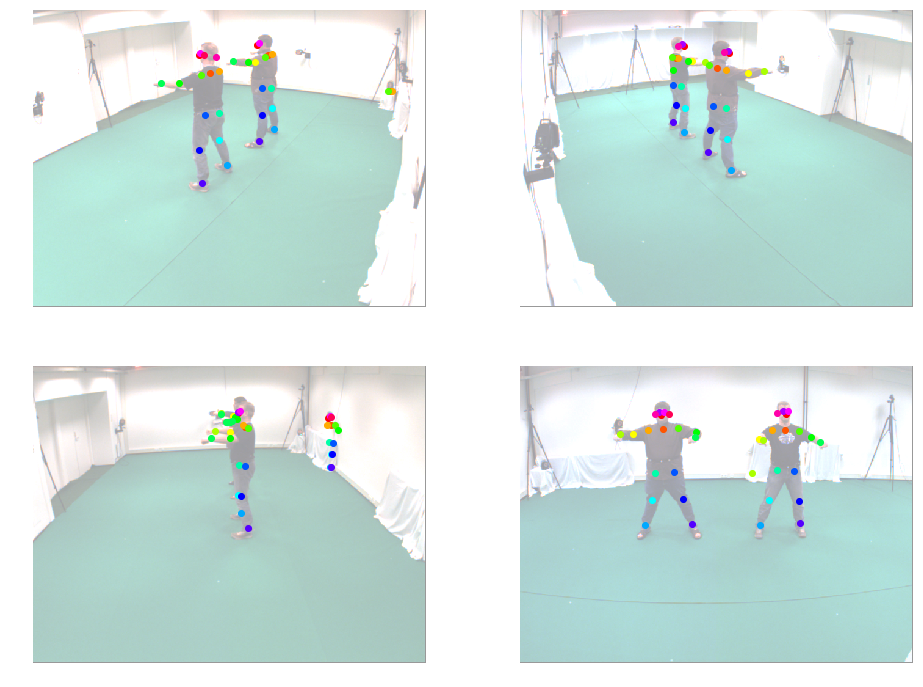

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
print('\n')
# ------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from os.path import isfile
import sys
from time import time
import cv2
import numpy as np
from os.path import join, isdir
sys.path.insert(0,'../../easy_multi_person_pose_estimation')
sys.path.insert(0,'../')
import mvpose.data.transform as tfm
import mvpose.geometry.geometry as gm
from mvpose.geometry import stereo
import mvpose.pose_estimation.heatmaps as mvhm
from mvpose.candidates import peaks as mvpeaks
import mvpose.pose_estimation.part_affinity_fields as mvpafs
from mvpose.data.default_limbs import  DEFAULT_LIMB_SEQ, DEFAULT_MAP_IDX
from mvpose.algorithm import graphcut
from cselect import color as cs

root = join(Settings['data_root'], 'pak')

from poseestimation import model
pe = model.PoseEstimator()


# interesting frames: [340, 215, 250]
FRAME = 0

from pak.datasets.UMPM import UMPM
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

X, Y, Calib = tfm.get_from_umpm(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])
with_gpu = False

if with_gpu:
    _start = time()
    heatmaps, pafs = pe.predict_pafs_and_heatmaps(I)
    _end = time(); print('elapsed:', _end - _start)
else:
    hm_file = '/tmp/heatmaps' + str(FRAME) + '.npy'
    paf_file = '/tmp/pafs' + str(FRAME) + '.npy'
    
    if isfile(hm_file) and isfile(paf_file):
        heatmaps = np.load(hm_file)
        pafs = np.load(paf_file)
    else:
        heatmaps = []; pafs = []
        for im in Im:
            _start = time()
            hm, paf = pe.predict_pafs_and_heatmaps(im)
            heatmaps.append(np.squeeze(hm))
            pafs.append(np.squeeze(paf))
            _end = time()
            print('elapsed:', _end - _start)
        heatmaps = np.array(heatmaps)
        pafs = np.array(pafs)
        np.save(hm_file, heatmaps)
        np.save(paf_file, pafs)
        
colors = cs.lincolor(19)/255

r = 200
_start = time()
Gr = graphcut.GraphCutSolver(heatmaps, pafs, Calib, r, debug=True)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(16,12))

for idx, im in enumerate(Im):
    ax = fig.add_subplot(2,2,idx+1)
    ax.imshow(im, alpha=0.4)
    ax.axis('off')
    
    for jid in range(Gr.peaks2d[idx].n_joints):
        for x,y,score in Gr.peaks2d[idx][jid]:
            ax.scatter(x,y, color=colors[jid])
    
plt.show()

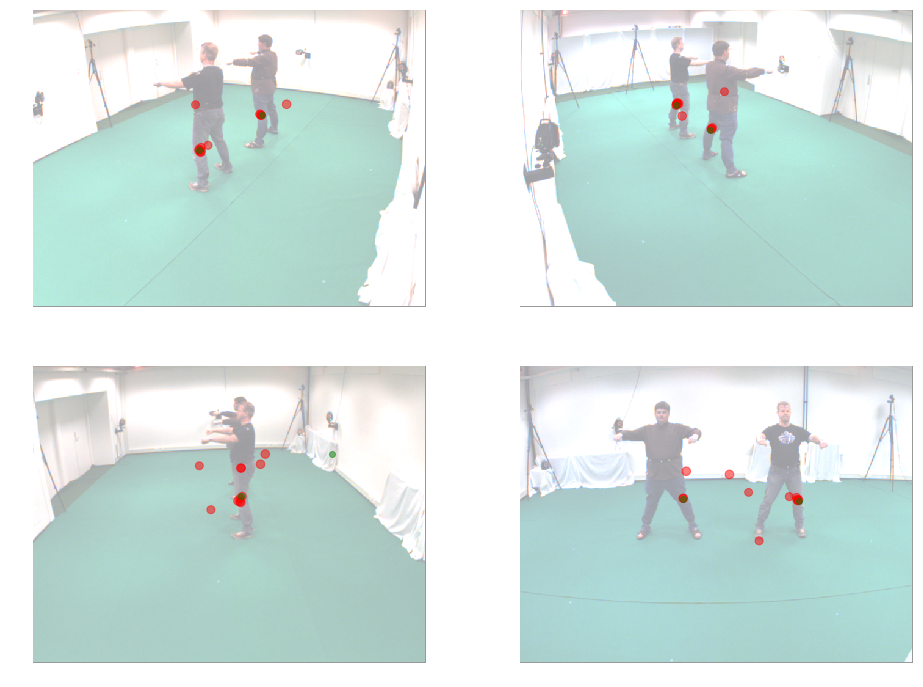

In [4]:
# 0 - Nose,  3 - elbow right,  10 - foot right,  12 - knee left,  13 - foot left
JOINT_ID = 12
Joints3d = Gr.peaks3d_weighted[JOINT_ID]

fig = plt.figure(figsize=(16,12))

# --- reproject ---
Pts3d = Joints3d[:,0:3]
Pts3d = Pts3d.astype('float64')

CANDIDATES = []

for idx, cam in enumerate(Gr.Calib_undistorted):
    ax = fig.add_subplot(2,2,1+idx)
    ax.axis('off')
    
    im = Im[idx]
    
    ax.imshow(im, alpha=0.4)
    
    Joints2d = Gr.candidates2d[idx][JOINT_ID]
    
    x = Joints2d[:,0]
    y = Joints2d[:,1]
    W = Joints2d[:,2] *  Joints2d[:,3]
    ax.scatter(x,y, alpha=0.5, s=W*100, color='red')
    
    nn_points = Gr.peaks2d[idx][JOINT_ID]
    CANDIDATES.append(nn_points)
    
    for x,y,score in nn_points:
        ax.scatter(x,y,  color='green', alpha=0.5)
    
    
plt.show()

(8, 7)

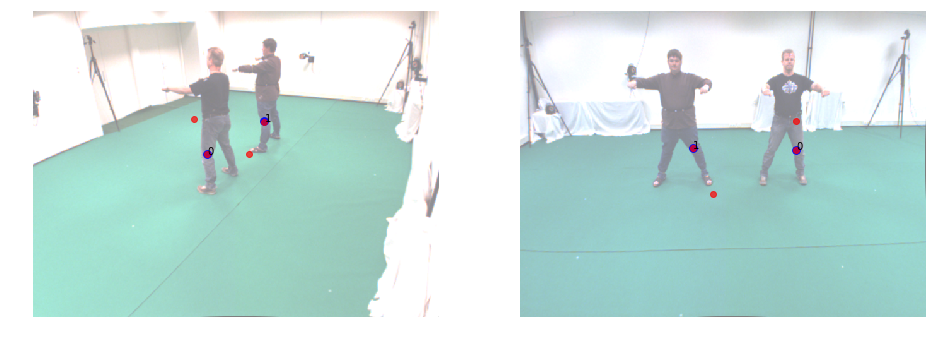

In [3]:
a = 0; b = 3

fig = plt.figure(figsize=(16,8))

sub_plots = []

for idx, cam in enumerate([a, b]):
    ax = fig.add_subplot(1,2,idx+1)
    ax.axis('off')
    mapx, mapy = Gr.undistort_maps[idx]
    sub_plots.append(ax)
    
    ax.imshow(cv2.remap(Im[cam], 
                        mapx, mapy, 
                        interpolation=cv2.INTER_LINEAR), alpha=0.5)
    
    for jid, (x,y,z) in enumerate(CANDIDATES[cam]):
        ax.scatter(x,y,color='blue', alpha=0.9, s=60)
        ax.text(x,y,str(jid))

# 0 - 0
candA = CANDIDATES[a]
candB = CANDIDATES[b]

K1, rvec1, tvec1, distCoef1 = gm.get_camera_parameters(Gr.Calib_undistorted[a])
K2, rvec2, tvec2, distCoef2 = gm.get_camera_parameters(Gr.Calib_undistorted[b])
assert distCoef1 == 0 and distCoef2 == 0
distCoef1 = np.array([0,0,0,0,0], 'float64')
distCoef2 = np.array([0,0,0,0,0], 'float64')

P1 = gm.get_projection_matrix_flat(K1, rvec1, tvec1)
P2 = gm.get_projection_matrix_flat(K2, rvec2, tvec2)

ids = []
Pt1 = []; Pt2 = []
for i, (x1,y1,_) in enumerate(candA):
    for j, (x2,y2,_) in enumerate(candB):
        Pt1.append((x1,y1))
        Pt2.append((x2,y2))
        ids.append((i,j))
        
        
pt1 = np.transpose(np.array(Pt1))
pt2 = np.transpose(np.array(Pt2))

pts3d = gm.from_homogeneous(
    np.transpose(cv2.triangulatePoints(P1, P2, pt1, pt2)))
pts3d = pts3d.astype('float64')


pts2dA, _ = cv2.projectPoints(pts3d, rvec1, tvec1, K1, distCoef1)
pts2dA = np.squeeze(pts2dA)

pts2dB, _ = cv2.projectPoints(pts3d, rvec2, tvec2, K2, distCoef2)
pts2dB = np.squeeze(pts2dB)


for ptA, ptB, (i,j) in zip(pts2dA, pts2dB, ids):
    ax = sub_plots[0]
    ax.scatter(ptA[0], ptA[1], color='red', alpha=0.7)
    
    ay = sub_plots[1]
    ay.scatter(ptB[0], ptB[1], color='red', alpha=0.7)

# ~~~~~~~~ TRIANGULATE WITH INTERNAL METHODS ~~~~~~~~~~~


my_points2dA = np.ones((len(Pt1), 3))
for i,(x,y) in enumerate(Pt1):
    my_points2dA[i,0] = x
    my_points2dA[i,1] = y
    
my_points2dB = np.ones((len(Pt2), 3))
for i,(x,y) in enumerate(Pt2):
    my_points2dB[i,0] = x
    my_points2dB[i,1] = y

peaks3d = stereo.triangulate_with_weights(
                    [my_points2dA], K1, rvec1, tvec1,
                    [my_points2dB], K2, rvec2, tvec2, max_epi_distance=100
                )

peaks3d[0].shape